In [ ]:
# Combined TF-IDF + Semantic Similarity + Random Forest Classifier

In [1]:

# Required Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Loading the dataset from hugging face
!pip install datasets
#loading the dataset
dataset = load_dataset("cnamuangtoun/resume-job-description-fit")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/53.4M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/15.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

In [6]:
train = dataset['train']
test = dataset['test']
train_data = pd.DataFrame(train)
test_data = pd.DataFrame(test)

In [7]:
# Preprocessing
def preprocess_text(text):
    return text.lower().strip()

train_data['resume_text'] = train_data['resume_text'].apply(preprocess_text)
train_data['job_description_text'] = train_data['job_description_text'].apply(preprocess_text)
test_data['resume_text'] = test_data['resume_text'].apply(preprocess_text)
test_data['job_description_text'] = test_data['job_description_text'].apply(preprocess_text)


In [8]:

# TF-IDF Features
vectorizer = TfidfVectorizer(max_features=5000)
train_combined_text = (train_data['resume_text'] + " " + train_data['job_description_text']).tolist()
test_combined_text = (test_data['resume_text'] + " " + test_data['job_description_text']).tolist()
X_tfidf_train = vectorizer.fit_transform(train_combined_text)
X_tfidf_test = vectorizer.transform(test_combined_text)


In [9]:
# Semantic Similarity Features
embedder = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeds = embedder.encode(test_data['resume_text'].tolist(), convert_to_tensor=False)
jd_embeds = embedder.encode(test_data['job_description_text'].tolist(), convert_to_tensor=False)
similarity_scores = np.diag(cosine_similarity(resume_embeds, jd_embeds)).reshape(-1, 1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])

In [11]:

# Combine TF-IDF + semantic similarity
X_combined_train = np.hstack([X_tfidf_train.toarray(), np.zeros((X_tfidf_train.shape[0], 1))])  # Pad training
X_combined_test = np.hstack([X_tfidf_test.toarray(), similarity_scores])  # Add similarity score to test set

In [12]:

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_combined_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_combined_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


               precision    recall  f1-score   support

     Good Fit       0.57      0.18      0.28       458
       No Fit       0.55      0.89      0.68       857
Potential Fit       0.43      0.21      0.29       444

     accuracy                           0.54      1759
    macro avg       0.52      0.43      0.41      1759
 weighted avg       0.52      0.54      0.48      1759

Confusion Matrix:
[[ 84 301  73]
 [ 41 763  53]
 [ 22 327  95]]


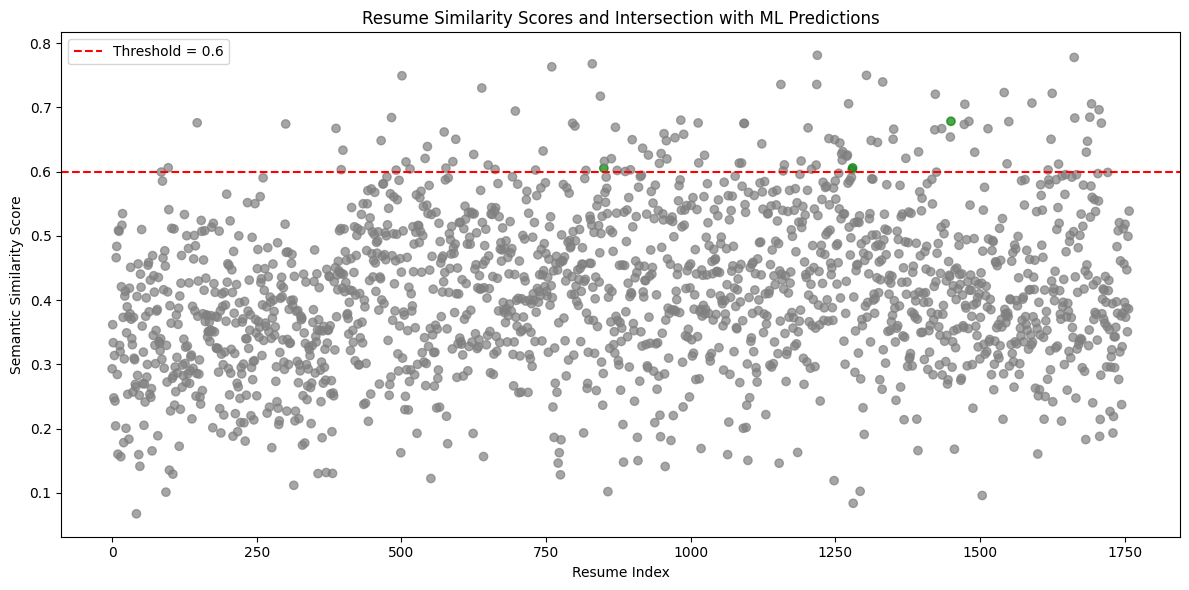

In [16]:
# Example: define threshold first
threshold = 0.6
similarity_matrix = cosine_similarity(resume_embeds, jd_embeds)
diagonal_scores = np.diag(similarity_matrix)

ml_predictions = rf_model.predict(X_combined_test)  # or use nb_model.predict(X_test)
ml_labels = label_encoder.inverse_transform(ml_predictions)

# Define a threshold (if not yet defined)
threshold = 0.6

# Build intersection: cases classified as 'Good Fit' AND have high similarity
intersection_indices = [
    i for i, (label, score) in enumerate(zip(ml_labels, diagonal_scores))
    if label == 'Good Fit' and score >= threshold
]
# Prepare color: green for intersection, gray otherwise
colors = ['green' if i in intersection_indices else 'gray' for i in range(len(diagonal_scores))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(diagonal_scores)), diagonal_scores, c=colors, alpha=0.7)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Resume Index')
plt.ylabel('Semantic Similarity Score')
plt.title('Resume Similarity Scores and Intersection with ML Predictions')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
print(f"Strong semantic + ML Good Fit matches: {len(intersection_indices)} out of {len(test_data)}")
for i in intersection_indices[:5]:
    print(f"\nSimilarity: {diagonal_scores[i]:.2f}")
    print(f"Resume:\n{test_data.iloc[i]['resume_text'][:300]}")
    print(f"JD:\n{test_data.iloc[i]['job_description_text'][:300]}")

Strong semantic + ML Good Fit matches: 3 out of 1759

Similarity: 0.61
Resume:
summaryto obtain a challenging position in the field of computer science and to and apply my analytical and technical skill sets to practice 5+ years of experience in the field of software development and testing
*hands-on experience with web and android mobile application development
*involved in a
JD:
role: java developer duration: 12 months required skills developed web application using java, j2ee, html, css, javascript, jquery, json, xml, javascript framework, bootstrap 3 or 4, angular, jsp (java server pages)angular framework, ajax

Similarity: 0.61
Resume:
professional summaryto obtain a challenging position in a dynamic atmosphere where my hard work and capabilities can efficiently utilized to develop the organisation as well as my career. experience summary over 7 years of software quality assurance experience in software requirement analysis, syste
JD:
role: java developer duration: 12 months requi